#1. inciando um estudo dirigido ao básico de DataScience
  1.1 importando uma biblioteca

In [ ]:
import numpy as np
import pandas as pd

#noemando o banco de daodos de dados_titanic
dados_titanic = pd.read_csv('titanic3.csv')
#listando as colunas 
#print(dados_titanic.columns)
 
#pclass: classe do passageiro
#survived: sobreviveu (1 = sim, 0 = não)
#name: nome
#sex: sexo
#age: idade
#sibsp: número de irmãos/cônjuges a bordo
#parch: número de pais/filhos a bordo
#ticket: número do bilhete
#fare: tarifa paga
#cabin: cabine
#embarked: porto de embarque
#boat: bote salva-vidas
#body: número do corpo (identificação de vítimas)
#home.dest: destino residencial

#renomeando colunas
dados_titinaic = dados_titanic.rename(columns={
    "pclass": "classe",
    "survived": "sobreviveu",
    "name": "nome",
    "sex": "sexo",
    "age": "idade",
    "sibsp": "irmaos_conjuges",
    "parch": "pais_filhos",
    "ticket": "bilhete",
    "fare": "tarifa",
    "cabin": "cabine",
    "embarked": "embarque",
    "boat": "bote_salva_vidas",
    "body": "numero_corpo",
    "home.dest": "destino_residencial"
}, inplace=True)

#convertendo as caolunas para o tipo de dados
dados_titanic1 = dados_titanic.astype({"idade": float,
                                        "sobreviveu": 'category',
                                         "tarifa": float,
                                          'sexo' : "category",
                                           'classe': 'category',
                                             'bilhete': 'category',
                                               "irmaos_conjuges": int,
                                                 "pais_filhos": int
                                                   })

#removendo valores missing (nulos)
dados_titanic1 = dados_titanic1.dropna(subset=["idade", "tarifa"])


In [49]:
#gerando alguns insights exploratorios
print(dados_titanic1.describe().loc[(["mean", 'std', 'min', "max", "50%"])])

          idade  irmaos_conjuges  pais_filhos      tarifa  numero_corpo
mean  29.851837         0.503349     0.421053   36.686080    160.033613
std   14.389194         0.912471     0.840052   55.732533     98.082975
min    0.170000         0.000000     0.000000    0.000000      1.000000
max   80.000000         8.000000     6.000000  512.329200    328.000000
50%   28.000000         0.000000     0.000000   15.750000    155.000000


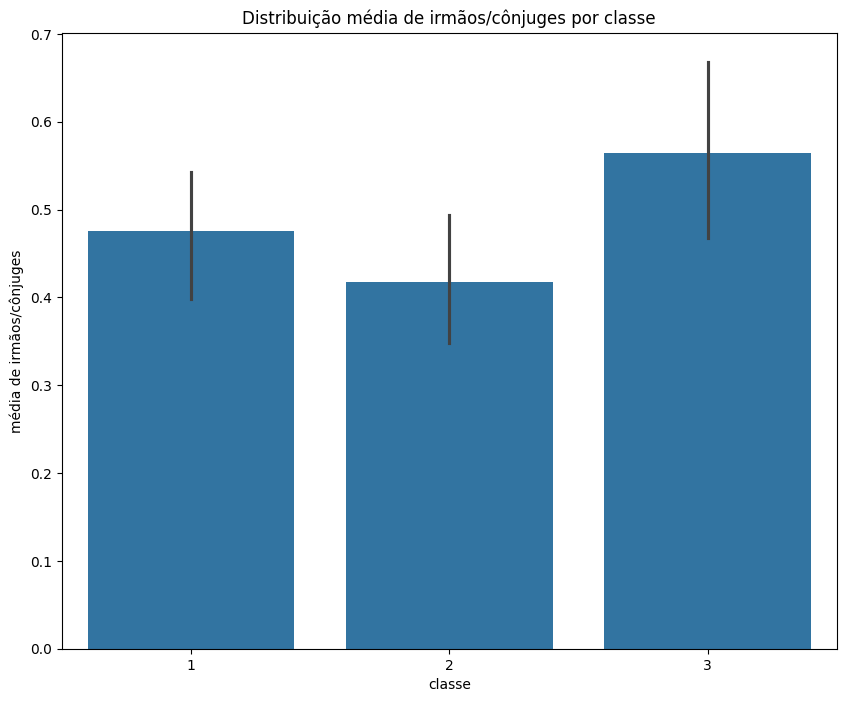

In [68]:
#graficos de barra para visualizar a distribuição das classes, sexo, bilhete e quem sobreviveu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))
sns.barplot(x = "classe", y = "irmaos_conjuges", data=dados_titanic1)
plt.title("Distribuição média de irmãos/cônjuges por classe")
plt.ylabel('média de irmãos/cônjuges')
plt.show()


C:\Users\fabia\AppData\Local\Temp\ipykernel_15204\1541130084.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dados_titanic1.groupby('classe')['irmaos_conjuges']


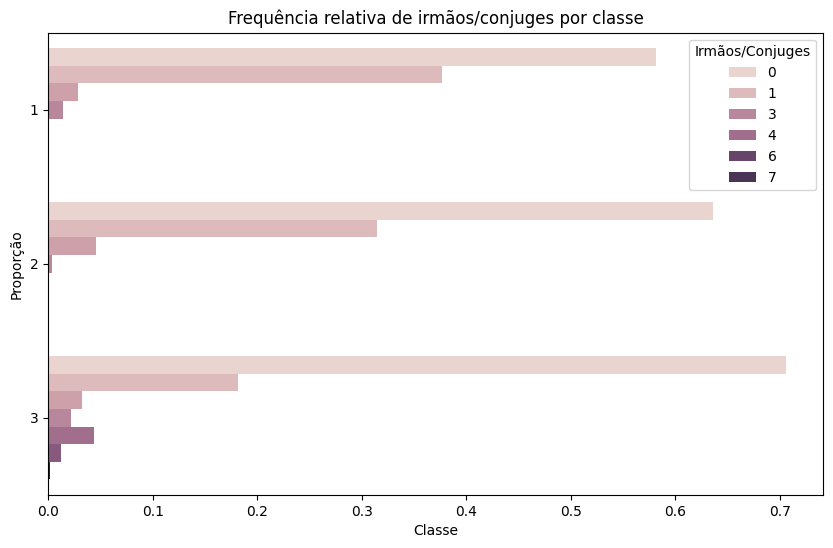

In [74]:
# Gráfico de barras com frequência relativa das classes usando seaborn
frequencia_irmaos = (
    dados_titanic1.groupby('classe')['irmaos_conjuges']
    .value_counts(normalize=True)
    .rename('proporcao')
    .reset_index()
)
plt.figure(figsize=(10,6))
sns.barplot(y='classe', x='proporcao', hue='irmaos_conjuges', data=frequencia_irmaos)
plt.title('Frequência relativa de irmãos/conjuges por classe')
plt.ylabel('Proporção')
plt.xlabel('Classe')
plt.legend(title='Irmãos/Conjuges')
plt.show()

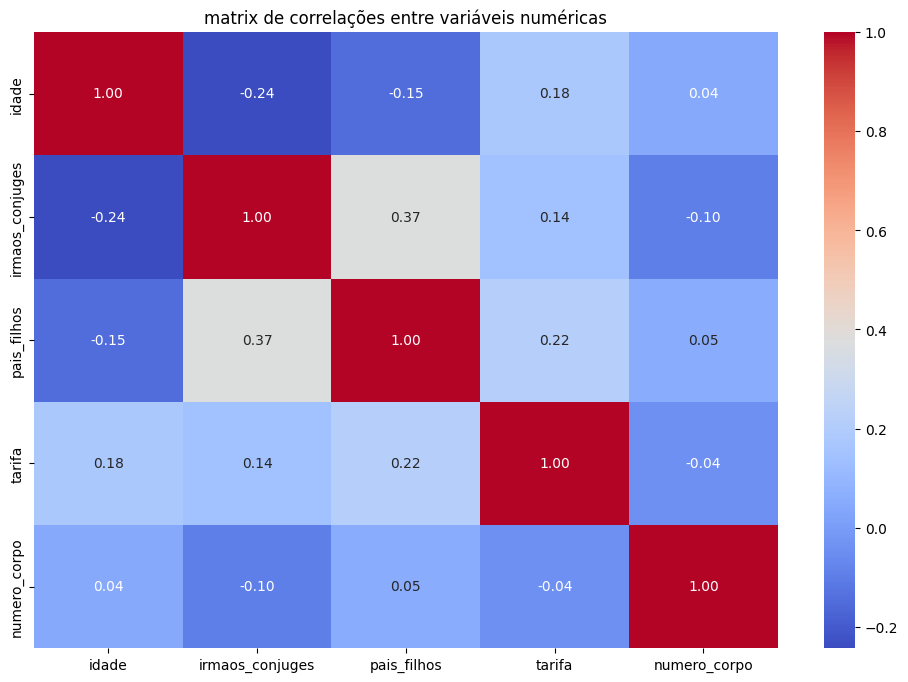

In [76]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
corr = dados_titanic1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
plt.show()

<Figure size 1200x800 with 0 Axes>

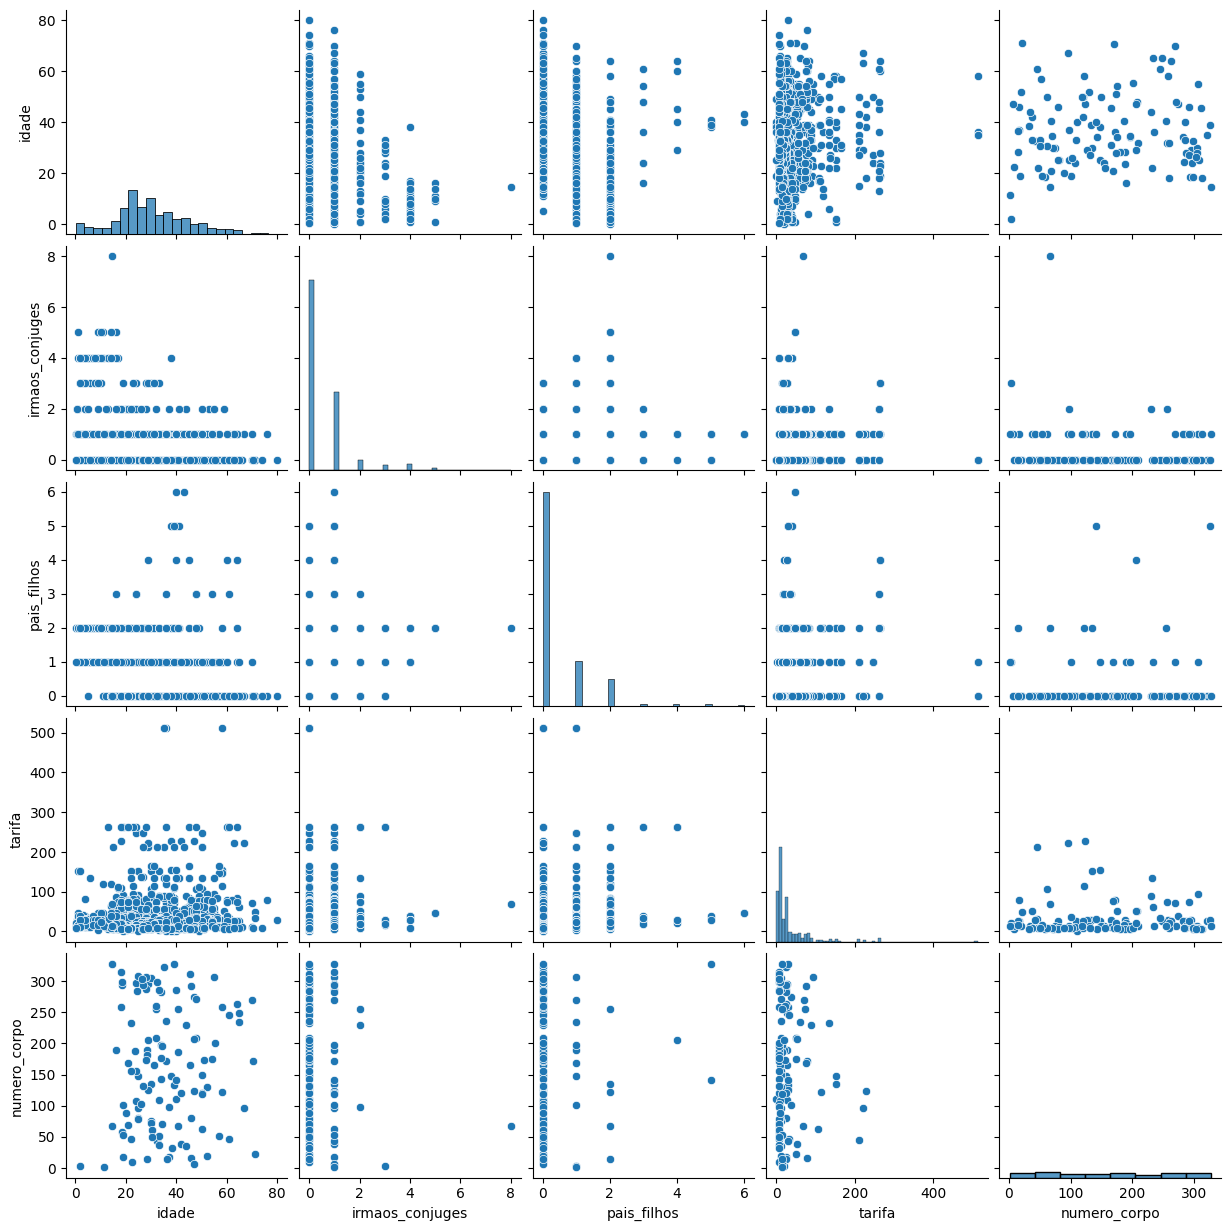

In [83]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
sns.pairplot(dados_titanic1)
#plt.title('matrix de correlações entre variáveis numéricas')
plt.show()

In [ ]:
# Teste de correlação entre variáveis numéricas: exemplo entre idade e tarifa
from scipy.stats import pearsonr
# Pearson
pearson_corr, pearson_p = pearsonr(dados_titanic1)
print(f'Pearson: correlação={pearson_corr:.2f}, p-valor={pearson_p:.4f}')


Pearson: correlação=0.18, p-valor=0.0000
Spearman: correlação=0.19, p-valor=0.0000
Kendall: correlação=0.13, p-valor=0.0000


In [82]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Ajustar modelo de regressão linear
modelo = LinearRegression()
modelo.fit(dados_titaniic[['']], dados['y'])

# Previsão da reta
x_pred = np.linspace(dados['x'].min(), dados['x'].max(), 100)
y_pred = modelo.predict(x_pred.reshape(-1, 1))

# Gráfico de dispersão e reta de regressão
plt.scatter(dados['x'], dados['y'], color='blue', label='Dados')
plt.plot(x_pred, y_pred, color='red', label='Regressão Linear')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Gráfico de pontos com reta de regressão')
plt.show()

KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     219.4
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           9.38e-27
Time:                        10:24:05   Log-Likelihood:                -292.09
No. Observations:                 100   AIC:                             588.2
Df Residuals:                      98   BIC:                             593.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0755      0.851      1.263      0.2

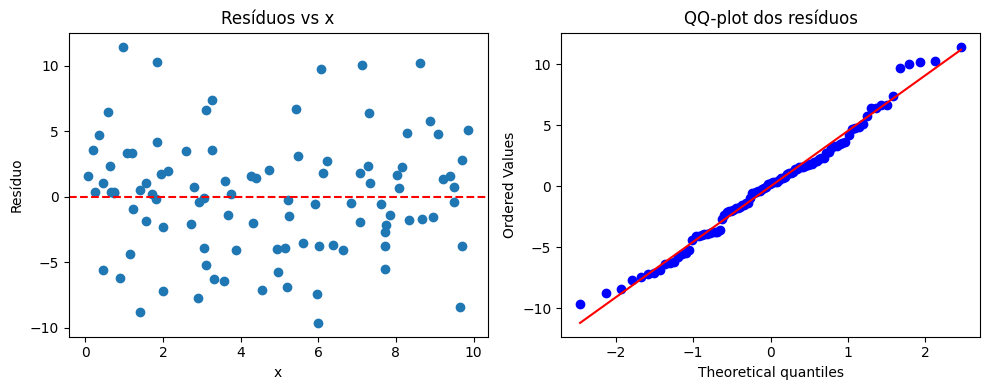

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats

# Ajuste do modelo de regressão linear com statsmodels
X = sm.add_constant(dados['x'])
modelo_sm = sm.OLS(dados['y'], X).fit()
print(modelo_sm.summary())

# Análise dos resíduos
residuos = modelo_sm.resid
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(dados['x'], residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('Resíduo')
plt.title('Resíduos vs x')

plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('QQ-plot dos resíduos')
plt.tight_layout()
plt.show()

# Teste de hipótese dos parâmetros
# O summary do modelo já mostra p-valores para os parâmetros
# Se p < 0.05, o parâmetro é considerado significativo

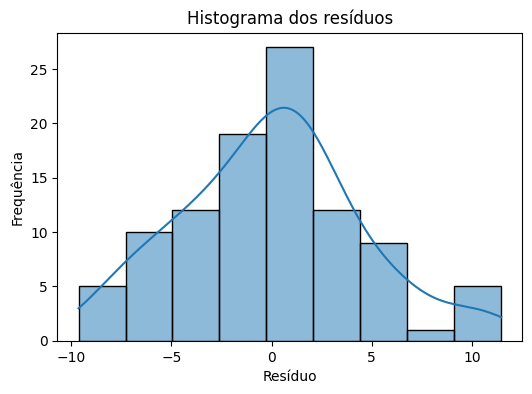

Teste de Shapiro-Wilk: estatística=0.9846, p-valor=0.2984
Os resíduos seguem distribuição normal (p >= 0.05)
Teste de Breusch-Pagan: estatística=0.0138, p-valor=0.9064
Não há evidência de heterocedasticidade (p >= 0.05)
Teste de Durbin-Watson: estatística=2.2850
Sem evidência de autocorrelação dos resíduos


In [ ]:
# Análise residual detalhada
import seaborn as sns

# 1. Histograma dos resíduos
plt.figure(figsize=(6,4))
sns.histplot(residuos, kde=True)
plt.title('Histograma dos resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

# 2. Teste de normalidade dos resíduos (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuos)
print(f'Teste de Shapiro-Wilk: estatística={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}')
if shapiro_test.pvalue < 0.05:
    print('Os resíduos NÃO seguem distribuição normal (p < 0.05)')
else:
    print('Os resíduos seguem distribuição normal (p >= 0.05)')

# 3. Teste de homocedasticidade (Breusch-Pagan)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos, X)
print(f'Teste de Breusch-Pagan: estatística={bp_test[0]:.4f}, p-valor={bp_test[1]:.4f}')
if bp_test[1] < 0.05:
    print('Há evidência de heterocedasticidade (p < 0.05)')
else:
    print('Não há evidência de heterocedasticidade (p >= 0.05)')

# 4. Teste de autocorrelação dos resíduos (Durbin-Watson)
dw = sm.stats.durbin_watson(residuos)
print(f'Teste de Durbin-Watson: estatística={dw:.4f}')
if dw < 1.5 or dw > 2.5:
    print('Possível autocorrelação dos resíduos')
else:
    print('Sem evidência de autocorrelação dos resíduos')